In [6]:
import os, sys, importlib, random; import xarray as xr; 
import pandas as pd; import matplotlib.pyplot as plt
from timeit import timeit, default_timer
import numpy as np; 
sys.path.append('/mnt/sda1/PhysOc/modview/modview/');
import loader, viztools
img_dir = '/home/noel/Documents/Research/AQDP/proc_figs/'

The procedure here is very straightforward (because the codebase in load_aqdp.py is strong!). Begin by importing module and loading raw aqdp data (profiles taken at 1 Hz).

In [2]:
import load_aqdp
importlib.reload(load_aqdp)
raw_dat = load_aqdp.build_raw()

Now let's separate all that data into chunks (ensembles) that last for 30 seconds each. Then, we will set up instances of the Veron and Wiles classes using those ensembles. Likewise, we create an instance of the class vehicle_motion that will have direct access to the formatted data. 

In [3]:
importlib.reload(load_aqdp); # reloading helps me update module in case I'm actively changing code
dt_seconds = 30;
ens = load_aqdp.Ensembles(dt_seconds, raw_dat); # separate into ensembles (chunks)
veron = load_aqdp.Veron(ens); # give turbulence methods access to data
wiles = load_aqdp.Wiles(ens); 
motion = load_aqdp.vehicle_motion(ens)

Will process 6791 ensembles lasting 30 s each.
The fitting range for the structure function method is [0.0884 0.442 ] meters


Altogether, instances of (1) Ensemble, (2) Wiles, (3) Veron, and (4) vehicle_motion will let us (1) extract raw measurements from raw_dat, (2) compute turbulence using structure functions, (3) compute turbulence using wavenumber spectra, and (4) compute metrics that may explain errors and uncertainties in the measurements. The fact that (2,3,4) are created using (1) as input ensures that data is always presented in a standard format and our results will be more traceable (every result is attached to an "index" that helps us extract the original data used to compute it). 

To see how this all works, let's run some of the main methods in (1,2,3,4) for a given ensemble (identified by an index). Here we use the method plot_obs_theory(), which is defined in the class TurbMethod(ABC), which is the parent class for both the veron and wiles classes. In each case, this method follows the appropriate steps to compute statistics from observations, fit theoretical curves, and then plot the results. Take a look at the code for that function for further details. 

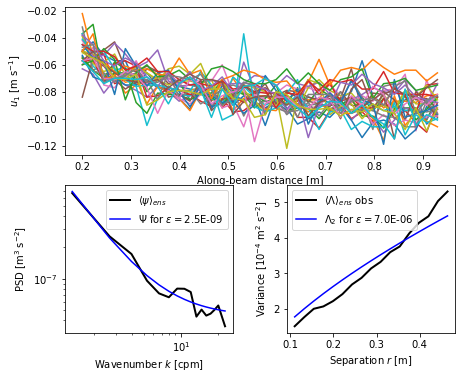

In [4]:
index = 236; # or whatever number we want
vels = ens.see_member(index); # extract velocity measurements for that index
# ---- prepare to plot
fig_dict = {'figsize':[7,6],'widths':[1,0.05,1],'heights':[1,1],
           'panels':([0,slice(0,3)],[1,0],[1,2])}
fig = viztools.panel_plot(fig_dict); fig.draw(); # take in figure settings and create visualization
fig.axes[0].plot( vels.length, vels.transpose() ) ; # plot velocity data
fig.axes[0].set_ylabel(r'$u_1$ [m s$^{-1}$]'); fig.axes[0].set_xlabel('Along-beam distance [m]')
# ---- turbulence estimates using the veron and wiles classes
veron.plot_obs_theory( fig.axes[1], index ) # calc obs_curve, fit theory_curve, and plot both.
fig.axes[1].legend()
wiles.plot_obs_theory( fig.axes[2], index )
fig.axes[2].legend()

This is all very nice (I hope), but it won't get us far when it comes to analyzing the data. We need results for more than one single index, and we need to save our results in a way that allows comparison. This is all done in the make_table function within aqdp_errors.py. In summary, make_table takes an instance of a turbulence method class (veron or wiles) and a list of indices. It returns a pandas dataframe including columns for a number of parameters that are useful to our analyses. 

In [61]:
import aqdp_errors
#import warnings
import importlib
#warnings.filterwarnings('error')
importlib.reload(aqdp_errors)
importlib.reload( load_aqdp )
indices = np.arange( 0, 1000, 50 ) 
# will want to do a non-random sample at some point
indices = np.sort(indices) # increasing order
veron_table = aqdp_errors.make_table( veron, indices )
#wiles_table = aqdp_errors.make_table( wiles, indices ) # these two lines will output pandas dataframes

# Homework for Ashton: figure out how to take these dataframes and save them into a file so that we 
# don't have to run the estimates again and again.

In [68]:
np.ceil( 2.01)

3.0

In [82]:
from datetime import datetime, timedelta

def date_to_num( datelist ):
    basetime = datetime( 2010, 1, 1, 0, 0);
    datenums = [ (jj - basetime).total_seconds()/3600 for jj in datelist ];
    return datenums

# Homework for Ashton: create num_to_date function. 
# Make plots of gridded data 

def make_taxis( table, dt=1 ):
    # dt is in hours
    t_0 = np.min( table['time'] )
    t_end = np.max( table['time'] )
    tnums = date_to_num( [t_0, t_end] );
    timevec = np.arange( np.floor(tnums[0]), np.ceil( tnums[1] ) + dt/2, dt );
    return timevec

def find_in_grid( table, t_axis, z_axis):
    # get space-time location of rows in table
    timenum = date_to_num( table['time'] );
    depth = table['depth'];
    # find which "bin" each measurement belongs to
    t_index = np.digitize( timenum, t_axis );
    z_index = np.digitize( depth, z_axis );
    return t_index, z_index

def grid_var( table, var ):
    # set edges of grid
    dz = 25; dt = 2; 
    z_axis = np.arange( 850, 1150, dz );
    t_axis = make_taxis( table, dt = dt )
    # find data within that grid
    t_ind, z_ind = find_in_grid( table, t_axis, z_axis );
    # create gridded variable
    gridded_var = np.zeros( [len(z_axis)-1, len(t_axis)-1] );
    
    for tt in range(1 , len(t_axis)):
        rows_now = (t_ind == tt)
        for zz in range(1 , len(z_axis)):
            # Find which table rows correspond to grid cell
            rows_here = ( z_ind == zz );
            # Extract rows from table that correspond to this grid cell
            rows_use = rows_now * rows_here 
            vals_use = table[var][rows_use]
            gridded_var[ zz-1, tt-1 ] = np.nanmean( vals_use )
    
    # resize t, z axes
    t_axis = t_axis[1:] - dt/2
    z_axis = z_axis[1:] - dz/2
    
    return gridded_var, t_axis, z_axis
    
    
epsi, t, z = grid_var( veron_table, 'epsilon')

<ipython-input-82-114d387a7fc3>:43: RuntimeWarning: Mean of empty slice
  gridded_var[ zz-1, tt-1 ] = np.nanmean( vals_use )


<ipython-input-83-54b4139d18a8>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh( t, z, np.log10( epsi ) )


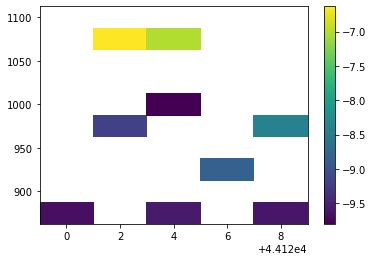

In [83]:
plt.pcolormesh( t, z, np.log10( epsi ) )
plt.colorbar() 

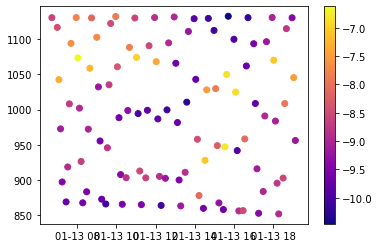

In [22]:
plt.scatter( veron_table['time'], 
           veron_table['depth'],
           c = np.log10( veron_table['epsilon']),
           cmap = 'plasma' )
plt.colorbar() 

In [25]:
#gridded_obs = load_aqdp.build_grid(); 
gridded_obs.keys()

dict_keys(['datenum', 'p', 'th', 's', 'u', 'v', 'yday', 'z', 'time'])

In [30]:
from datetime import datetime, timedelta
t0 = datetime(2015, 1 , 25, 12, 0); dt = 1.5; # hours
timevec = [ t0 + kk*timedelta( hours = dt ) for kk in range(10) ]
for date in timevec:
    print( date )

2015-01-25 12:00:00
2015-01-25 13:30:00
2015-01-25 15:00:00
2015-01-25 16:30:00
2015-01-25 18:00:00
2015-01-25 19:30:00
2015-01-25 21:00:00
2015-01-25 22:30:00
2015-01-26 00:00:00
2015-01-26 01:30:00


In [50]:
from scipy.optimize import differential_evolution 

def setup_optimization( turb_inst, index ):
    obs_curve = turb_inst.observations_curve( index );
    degfred = obs_curve.shape[0]; 
    obs_curve = np.mean( obs_curve, axis = 0 )
    # find parameters that minimize cost function
    return obs_curve, degfred

def calc_times( turb_inst, index ):
    start = default_timer() 
    arg_tup = setup_optimization( veron, index );
    obs_end = default_timer(); # timecheck
    optimal = differential_evolution( func=turb_inst.cost_function, 
                        bounds = [(1e-11, 1e-5), (0,5e-4)], args = arg_tup,
                        maxiter = 40, popsize = 6 )
    opt_end = default_timer() 
    obs_time = obs_end - start; 
    opt_time = opt_end - obs_end; 
    return obs_time, opt_time, optimal


veron_times = {'obs_curve':[], 'optimization':[],'vals':[] }
wiles_times = {'obs_curve':[], 'optimization':[], 'vals':[] }
N = 25;
my_inds = np.arange( 4, 121, 4 );
for jj in range( N ):
    ind = my_inds[jj]
    #ind = np.random.randint( 5000 )
    
    # Do veron first
    obs_time, opt_time, result = calc_times( veron, ind )
    veron_times['obs_curve'].append( obs_time )
    veron_times['optimization'].append( opt_time )
    veron_times['vals'].append( result.x )
    
    # Now do wiles
    obs_time, opt_time, result = calc_times( wiles, ind )
    wiles_times['obs_curve'].append( obs_time )
    wiles_times['optimization'].append( opt_time )
    wiles_times['vals'].append( result.x )


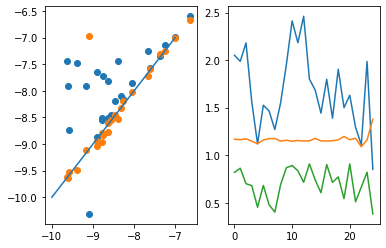

In [59]:
#veron_nc = veron_times.copy(); 
#wiles_nc = wiles_times.copy() 
# What's the effect of setting maxiter=20?
#wiles_iter20 = wiles_times.copy();
#veron_iter20 = veron_times.copy(); 
# ------ another setting with maxiter=40, popsize=6
wiles_both = wiles_times.copy(); 
veron_both = veron_times.copy();

def get_eps( time_dict ):
    vals = time_dict['vals'];
    eps = [ ll[0] for ll in vals ];
    return np.log10(eps)

#plt.scatter( get_eps(veron_nc), get_eps(veron_times) )
fig, ax = plt.subplots(ncols=2)

ax[0].scatter( get_eps(veron_nc), get_eps( veron_iter20 ) )
ax[0].scatter( get_eps(veron_nc), get_eps( veron_both ) )
ax[0].plot([-10,-7],[-10,-7])

ax[1].plot( veron_nc['optimization'])
ax[1].plot( veron_iter20['optimization'] )
ax[1].plot( veron_both['optimization'])

In [32]:
arg_tup = setup_optimization( veron, 2351 )
optimal = differential_evolution( func=veron.cost_function, 
                        bounds = [(1e-11, 1e-5), (0,5e-4)], args = arg_tup  )
optimal

     fun: -240.1316573845653
 message: 'Optimization terminated successfully.'
    nfev: 1083
     nit: 35
 success: True
       x: array([8.75829181e-10, 1.21129947e-07])

In [15]:
importlib.reload( aqdp_errors )
importlib.reload( load_aqdp )

my_motion = load_aqdp.vehicle_motion( ens )
aqdp_errors.unpack_orientation( my_motion, 35, [[],[],[]], None )

[[<xarray.DataArray 'roll' (time: 29)>
  array([7. , 6.4, 6.4, 6.2, 6.4, 6. , 5.5, 6.3, 6.6, 8. , 7.7, 7.2, 6.5,
         6.9, 6.6, 6.5, 5.9, 5.4, 5. , 5.6, 5.9, 6.1, 6.6, 7.1, 7.7, 7.6,
         6.6, 6.4, 5.3])
  Coordinates:
    * time     (time) datetime64[ns] 2015-01-13T07:11:16.000001 ... 2015-01-13T...],
 [array([34.8, 44.7, 35.5, 41.5, 37.6, 39.1, 46.1, 37.6, 52.2, 45.2, 48.3,
         31.5, 41.4, 37.2, 38.5, 45.5, 42.7, 49.4, 41.4, 53.2, 46.9, 48.5,
         43.6, 48.8, 51.7, 35.1, 46.1, 35.3, 38.6])],
 [<xarray.DataArray 'pitch' (time: 29)>
  array([17.4, 17.8, 18. , 17.8, 18. , 18.1, 18.1, 18. , 17.6, 17.1, 17.1,
         17.5, 17.6, 17.7, 17.8, 17.9, 18. , 18.3, 18.4, 18.4, 18.1, 18. ,
         17.8, 17.4, 17.1, 17.2, 17.6, 17.9, 18.2])
  Coordinates:
    * time     (time) datetime64[ns] 2015-01-13T07:11:16.000001 ... 2015-01-13T...]]

In [58]:
importlib.reload( load_aqdp )
importlib.reload( aqdp_errors )
indices = np.arange( 0, 1000, 20)
table = aqdp_errors.make_table( wiles, indices )

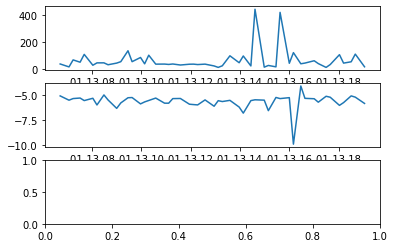

In [67]:
fig, ax = plt.subplots( 3 )

ax[0].plot( table['time'], table['hdg_var'] )
ax[1].plot( table['time'], np.log10(table['epsilon']) )

Text(0, 0.5, 'log(epsilon) - Veron')

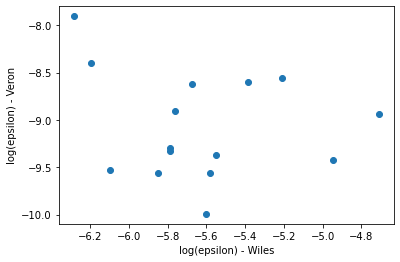

In [7]:
# Let's do a simple comparison of one method against the other. 
plt.scatter( np.log10(wiles_table['epsilon']), 
                      np.log10(veron_table['epsilon']))
#plt.scatter( vert_vel, ), label='Wiles method' )
plt.xlabel('log(epsilon) - Wiles')
plt.ylabel('log(epsilon) - Veron')

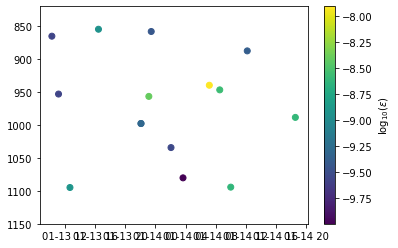

In [8]:
# Now another visualization: a time-depth section 
# this makes more sense when we compute for a one-by-one list of indices,
# rather than a random sample
plt.scatter( veron_table['time'], veron_table['depth'], 
            c = np.log10( veron_table['epsilon'] ) )
plt.ylim([1150, 820]); plt.colorbar(label=r'$\log_{10} (\varepsilon)$')

In [9]:
# Homework for Ashton: (1) make a histogram of vertical velocity
# (2) use what you learn from that to "group" the rows of tables according to 
# their vertical velocity. Then, draw histograms of log(epsilon) for each of those groups 
# draw them on top of each other so we can clearly see their differences.

In case you're wondering... how are we finding the optimal values of epsilon and the spectral noise floor? 
Both the wiles and veron classes have methods called cost_function(). These are measures that compare a theoretical curve to the observations available, and the goal is to find parameters for the theoretical curve that will minimize this cost function. The method estimate_epsilon, which belongs to TurbMethod(ABC) and is accessed by both the Wiles and Veron classes takes care of this: it uses an algorithm called "differential_evolution" that works some black magic and finds the optimal parameters. I say "black magic" because I don't really know how it works, but we can test whether or not it works. That's exactly what we'll do below:

<ipython-input-10-c3504447f8a4>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = plt.pcolormesh( np.log10(eps_trial), np.log10(floor_trial),


Text(0.5, 1.0, 'Is black dot in minimum of cost function?')

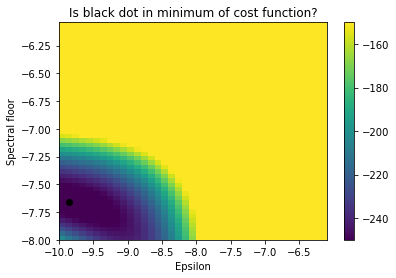

In [10]:
# Plot the cost function for a given index at many different values of epsilon and spectral noise floor
index = 440;
observ = veron.observations_curve(index); # get observational spectra
degfred = observ.shape[0];
observ = np.mean(observ,axis=0); # compute ensemble average
eps_trial = 10**(np.arange(-10,-6,0.1)) # all values of epsilon we will try
floor_trial = 10**(np.arange(-8,-6,0.04)); # all values of noise floor we will try
cost = np.zeros( (len(eps_trial), len(floor_trial)) ) # empty array to save our results
for kk in range(len(eps_trial)):
    for jj in range(len(floor_trial)):
        parameters = [eps_trial[kk], floor_trial[jj]]; # combination of parameters to use
        # for each combo, compute theoretical curve and compare to observations (cost function)
        cost[kk,jj] = veron.cost_function(parameters, 
                            observ, degfred)
# --- now that we tried all those values... let's see what the optimization algorithm gives us:
solution = veron.estimate_epsilon( index ); 

# --- plot the cost function for all values used
img = plt.pcolormesh( np.log10(eps_trial), np.log10(floor_trial), 
               cost.transpose(), vmin=-250, vmax=-150)
# --- draw black circle in optimal solution according to differential_evolution
plt.scatter( np.log10(solution[0]), np.log10(solution[1]), color='black')
plt.xlabel('Epsilon'); plt.ylabel('Spectral floor')
plt.colorbar(img); plt.title('Is black dot in minimum of cost function?')

In [84]:
grid_data = load_aqdp.build_grid() 

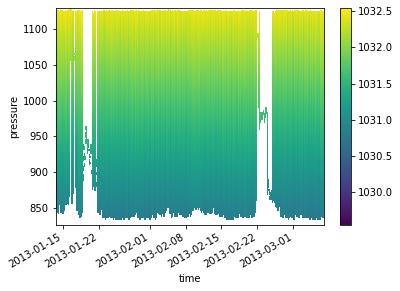

In [98]:
# Richardson Number N^2 / S^2 
#grid_data['th'] # conservative temperature
import gsw 
gsw.rho( grid_data['s'], grid_data['th'], grid_data['u'].pressure ).plot()
#grid_data['u'].differentiate(coord='pressure').plot(vmin=-0.02, vmax=0.02)

In [91]:
grid_data['u']

<xarray.DataArray (pressure: 152, time: 2372)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * pressure  (pressure) uint16 827 829 831 833 835 ... 1121 1123 1125 1127 1129
  * time      (time) datetime64[ns] 2013-01-13T16:30:03.000004 ... 2013-03-06...